In [1]:
import graspy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from twins import load_dataset
%matplotlib inline

/Users/j1c/miniconda3/envs/graspy/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
graphs = load_dataset(parcellation='desikan', preprocess=None, ptr=None)[0]

df = pd.read_csv('../../../../../twins/data/raw/unrestricted_jaewonc78_1_20_2019_23_7_58.csv')

In [3]:
gender = []
for sub in graphs.keys():
    gender.append(df[df.Subject == int(sub)]['Gender'].values[0])

In [4]:
le = LabelEncoder()
labels = le.fit_transform(gender)
# 1 is male, 0 is female

In [5]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([535, 449]))

In [6]:
male_graphs = []
female_graphs = []

for idx, (sub, graph) in enumerate(graphs.items()):
    if labels[idx] == 1:
        male_graphs.append(graph)
    else:
        female_graphs.append(graph)
        
male_graphs = np.array(male_graphs)
female_graphs = np.array(female_graphs)

male_graphs[male_graphs > 0] = 1
female_graphs[female_graphs > 0] = 1

In [7]:
male_graphs_mean = male_graphs.mean(axis=0)
female_graphs_mean = female_graphs.mean(axis=0)

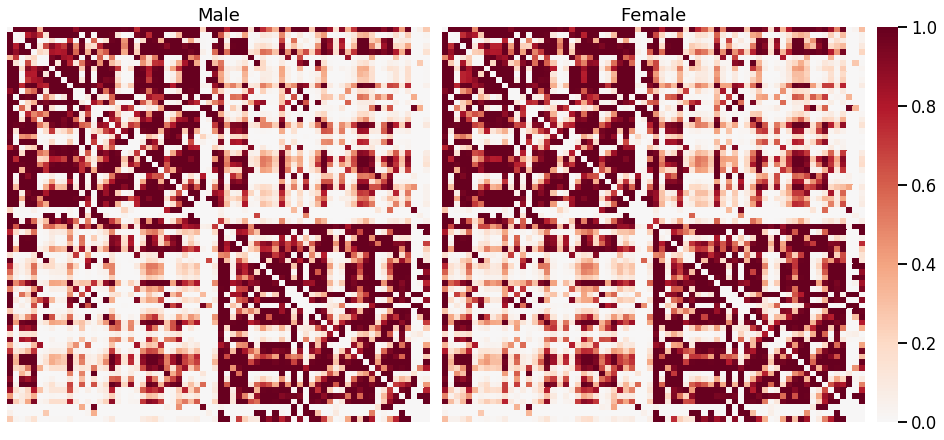

In [8]:
titles = ['Male', 'Female']

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(
        figsize=(13, 6),
        ncols=3, 
        gridspec_kw={"width_ratios": [1, 1, 0.05]},
        constrained_layout=True
    )
    for idx, mat in enumerate([male_graphs_mean, female_graphs_mean]):
        sns.heatmap(
            mat, 
            vmin=0,
            vmax=1, 
            cmap='RdBu_r',
            center=0,
            ax = ax[idx],
            cbar_ax = ax[-1],
            xticklabels=False,
            yticklabels=False
        )
        ax[idx].set_title(titles[idx])
        
#fig.savefig("./figures/20200301_avg_gender_hcp.png", dpi=300, bbox_inches=False)
#fig.savefig("./figures/20200301_avg_gender_hcp.pdf", dpi=300, bbox_inches=False)

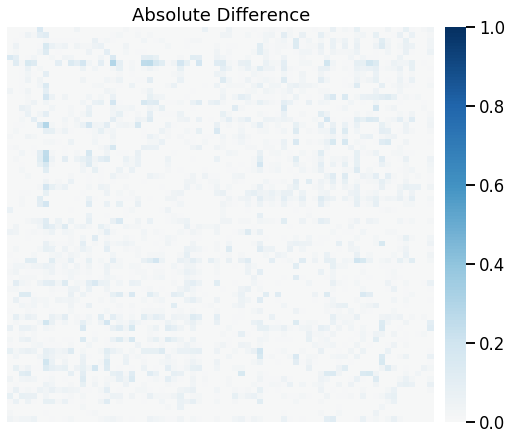

In [9]:
diffs = np.abs(female_graphs_mean - male_graphs_mean)

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(
        figsize=(7, 6),
        ncols=2, 
        gridspec_kw={"width_ratios": [1, 0.05]},
        constrained_layout=True
    )
    sns.heatmap(
        diffs, 
        vmin=0,
        vmax=1, 
        cmap='RdBu',
        center=0,
        ax = ax[0],
        cbar_ax = ax[-1],
        xticklabels=False,
        yticklabels=False
    )
    ax[0].set_title("Absolute Difference")
    
#fig.savefig("./figures/20200301_abs_diff_gender_hcp.png", dpi=300, bbox_inches=False)
#fig.savefig("./figures/20200301_abs_diff_gender_hcp.pdf", dpi=300, bbox_inches=False)

In [10]:
exp_res = pd.read_csv("../20200206_results.csv")
exp_res.head()

,p,delta,m,precision_at_5,precision_at_6,precision_at_7,precision_at_8,precision_at_9,precision_at_10,recall_at_5,recall_at_6,recall_at_7,recall_at_8,recall_at_9,recall_at_10
0,0.5,0.000,14.9,0.078,0.076667,0.068571,0.06750,0.064444,0.061,0.039,0.046,0.048,0.054,0.058,0.061
1,0.5,0.005,14.9,0.042,0.046667,0.054286,0.05625,0.057778,0.058,0.021,0.028,0.038,0.045,0.052,0.058
2,0.5,0.010,14.9,0.054,0.053333,0.051429,0.05375,0.055556,0.056,0.027,0.032,0.036,0.043,0.050,0.056
3,0.5,0.015,14.9,0.070,0.065000,0.065714,0.06375,0.063333,0.062,0.035,0.039,0.046,0.051,0.057,0.062
4,0.5,0.020,14.9,0.072,0.068333,0.071429,0.06750,0.068889,0.068,0.036,0.041,0.050,0.054,0.062,0.068


In [11]:
exp_res = exp_res[exp_res.m == 500]

In [12]:
diffs = np.abs(female_graphs_mean - male_graphs_mean)
empirical_trustworthiness = np.zeros_like(diffs) 

deltas = exp_res.delta.values
trustworthiness = exp_res.recall_at_10.values

for i in range(diffs.shape[0]):
    for j in range(i + 1, diffs.shape[0]):
        diff = diffs[i, j]
        empirical_delta = np.argmin(np.abs(deltas - diff))
        empirical_trustworthiness[i, j] = trustworthiness[empirical_delta]
        
empirical_trustworthiness = graspy.utils.symmetrize(empirical_trustworthiness, 'triu')

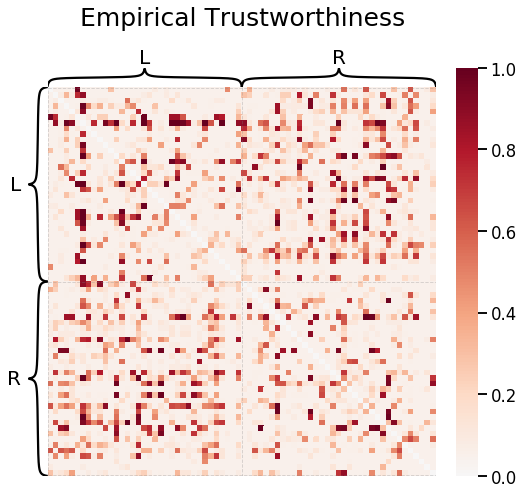

In [13]:
node_labels = ['L'] * 35 + ['R'] * 35

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(
        figsize=(7, 6),
        ncols=2, 
        gridspec_kw={"width_ratios": [1, 0.05]},
        constrained_layout=True
    )

    graspy.plot.heatmap(empirical_trustworthiness, inner_hier_labels=node_labels,
                        vmin=0, vmax=1, ax=ax[0], cbar_ax=ax[-1],
                       hier_label_fontsize=20)

    fig.text(.45, 1.075, "Empirical Trustworthiness", fontsize=25, ha='center')
    #ax[0].set_title("Empirical Trustworthiness")
    
fig.savefig("./exp1_empirical_trustworthiness.png", dpi=300, bbox_inches='tight')
fig.savefig("./exp1_empirical_trustworthiness.pdf", dpi=300, bbox_inches='tight')